In [1]:
import os
import sys
import math
import random
import joblib
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
import matplotlib.pyplot as plt

In [3]:
sale = pd.read_excel(os.path.join('..', '..', '0.Data', '01_제공데이터', '2020 빅콘테스트 데이터분석분야-챔피언리그_2019년 실적데이터_v1_200818.xlsx'), skiprows = 1)

In [4]:
sale.head()

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액
0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0
1,2019-01-01 06:00:00,NaN,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0
2,2019-01-01 06:20:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000.0
3,2019-01-01 06:20:00,NaN,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000.0
4,2019-01-01 06:40:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000.0


In [61]:
test = pd.read_excel(os.path.join('..', '..', '0.Data', '02_평가데이터', '2020 빅콘테스트 데이터분석분야-챔피언리그_2020년 6월 판매실적예측데이터(평가데이터).xlsx'), skiprows = 1)

In [5]:
# 아이템 메타 만들기

In [6]:
meta_train = pd.read_excel(os.path.join('..', '..', '0.Data', '01_제공데이터', 'train수작업_meta.xlsx'))
meta_test = pd.read_excel(os.path.join('..', '..', '0.Data', '02_평가데이터', 'test수작업_meta.xlsx'))

In [7]:
meta_train = meta_train.loc[meta_train['상품군'] != '무형']
meta_test = meta_test.loc[meta_test['상품군'] != '무형']

In [8]:
meta = pd.concat([meta_train, meta_test], axis = 0)

In [9]:
item = meta.loc[meta['NEW상품명'].notnull(), 'NEW상품명'].drop_duplicates().reset_index(drop = True).reset_index().rename(columns = {'index' : 'NEW상품코드'})
item.head()

,NEW상품코드,NEW상품명
0,0,가이거 남성 블랙 에디션 다이아몬드 워치
1,1,가이거 무빙스타 다이아몬드 워치
2,2,가이거 무빙스타 다이아몬드 워치 + 보석함
3,3,가이거 여성 블랙 에디션 다이아몬드 워치
4,4,가이거 제니스시계 주얼리세트


In [10]:
item

,NEW상품코드,NEW상품명
0,0,가이거 남성 블랙 에디션 다이아몬드 워치
1,1,가이거 무빙스타 다이아몬드 워치
2,2,가이거 무빙스타 다이아몬드 워치 + 보석함
3,3,가이거 여성 블랙 에디션 다이아몬드 워치
4,4,가이거 제니스시계 주얼리세트
...,...,...
1617,1617,QISS 프리미어 아침에 끌리다 마시는한끼 21통
1618,1618,QISS 프리미어 아침에 끌리다 마시는한끼 42통
1619,1619,W클라우드 남성 데일리 트레킹화 3종
1620,1620,W클라우드 여성 데일리 트레킹화 3종


In [13]:
sale = sale.merge(meta.drop_duplicates('상품코드')[['상품코드', 'NEW상품명']], on = '상품코드', how = 'left').merge(item, on = 'NEW상품명', how = 'left')

In [14]:
sale['NEW상품코드'].nunique()

1355

# 0. 데이터 전처리(판매량 및 날짜 생성)

In [16]:
# 판매량
import math
sale['판매량'] = sale['취급액'] / sale['판매단가']
sale['판매량'] = sale['판매량'].fillna(0).apply(lambda x : math.ceil(x))

In [19]:
sale['방송날'] = sale['방송일시'].dt.date
sale['방송월'] = sale['방송일시'].dt.month
sale['방송일'] = sale['방송일시'].dt.day
sale['방송시간'] = sale['방송일시'].dt.hour

In [20]:
# 11월 1일부터 바뀐 편성표 시간 맞춰주기
sale_a = sale.loc[sale['방송일시'] < '2019-11-01 02:00:00']
sale_b = sale.loc[sale['방송일시'] > '2019-11-01 02:00:00']

In [23]:
sale_a['방송날'] = sale_a.apply(lambda x : datetime.datetime.combine(x['방송날'], datetime.time(x['방송시간'])), axis = 1)

In [30]:
sale_b['new_방송일시'] = sale_b['방송일시'] - datetime.timedelta(minutes = 20)

In [31]:
sale_b['방송날'] = sale_b['new_방송일시'].dt.date
sale_b['방송월'] = sale_b['new_방송일시'].dt.month
sale_b['방송일'] = sale_b['new_방송일시'].dt.day
sale_b['방송시간'] = sale_b['new_방송일시'].dt.hour

In [32]:
sale_b['방송날'] = sale_b.apply(lambda x : datetime.datetime.combine(x['방송날'], datetime.time(x['방송시간'])), axis = 1)

In [35]:
sale_raw = pd.concat([sale_a.drop('방송일시', axis = 1), sale_b.drop(['방송일시', 'new_방송일시'], axis = 1)], axis = 0)

In [38]:
sale_raw.groupby(['방송날'])['방송월'].count()

방송날
2019-01-01 06:00:00     6
2019-01-01 07:00:00     3
2019-01-01 08:00:00     3
2019-01-01 09:00:00     3
2019-01-01 10:00:00     3
                       ..
2019-12-31 21:00:00     6
2019-12-31 22:00:00     3
2019-12-31 23:00:00    12
2020-01-01 00:00:00     3
2020-01-01 01:00:00     2
Name: 방송월, Length: 7294, dtype: int64

In [43]:
sale_raw.sort_values(['방송날', '취급액'], ascending = [True, False]).drop_duplicates(['방송날'])

,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,NEW상품명,NEW상품코드,판매량,방송날,방송월,방송일,방송시간
5,NaN,100346,201079,테이트 여성 셀린니트3종,의류,39900,9337000.0,테이트 여성 셀린 니트 3종,860.0,235,2019-01-01 06:00:00,1,1,6
8,20.0,100305,200974,오모떼 레이스 파운데이션 브라,속옷,59000,25370000.0,오모떼 여성 레이스 파운데이션 브라,627.0,430,2019-01-01 07:00:00,1,1,7
11,20.0,100808,202377,CERINI by PAT 남성 소프트 기모 릴렉스팬츠,의류,59900,53542000.0,CERINI by PAT 남성 소프트 기모 릴렉스 팬츠,1072.0,894,2019-01-01 08:00:00,1,1,8
14,20.0,100816,202404,보코 리버시블 무스탕,의류,79000,49270000.0,보코 리버시블 무스탕,377.0,624,2019-01-01 09:00:00,1,1,9
17,20.0,100809,202395,CERINI by PAT 남성 풀패키지 기모니트 3종,의류,79900,112972000.0,CERINI by PAT 남성 풀패키지 기모 니트 3종,1082.0,1414,2019-01-01 10:00:00,1,1,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38287,20.0,100155,200556,일시불 LG전자 매직스페이스 냉장고,가전,1359000,72733000.0,LG 매직스페이스 냉장고,1113.0,54,2019-12-31 21:00:00,12,31,21
38289,20.0,100543,201624,넥센타이어 렌탈서비스,무형,0,NaN,NaN,NaN,0,2019-12-31 22:00:00,12,31,22
38301,NaN,100448,201390,일시불쿠첸압력밥솥 10인용,주방,168000,104392000.0,쿠첸 압력밥솥 10인용,813.0,622,2019-12-31 23:00:00,12,31,23
38304,20.0,100073,200196,삼성화재 행복한파트너 주택화재보험(1912),무형,0,NaN,NaN,NaN,0,2020-01-01 00:00:00,1,1,0


In [46]:
sale_raw.groupby('방송날')['마더코드'].nunique().sort_values()

방송날
2019-01-01 06:00:00    1
2019-08-29 09:00:00    1
2019-08-29 08:00:00    1
2019-08-29 07:00:00    1
2019-08-29 06:00:00    1
                      ..
2019-12-21 13:00:00    3
2019-12-24 20:00:00    3
2019-03-23 20:00:00    3
2019-12-17 14:00:00    3
2019-03-23 21:00:00    3
Name: 마더코드, Length: 7294, dtype: int64

In [48]:
sale_raw.loc[(sale_raw['방송월'] == 12) & (sale_raw['방송일'] == 21) & (sale_raw['방송시간'] == 13)]

,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,NEW상품명,NEW상품코드,판매량,방송날,방송월,방송일,방송시간
37333,30.1,100036,200068,구찌 씨마 베이직 양면 울 머플러,잡화,380000,5322000.0,구찌 씨마 베이직 양면 울 머플러,16.0,15,2019-12-21 13:00:00,12,21,13
37334,NaN,100036,200069,구찌 인터로킹 GG 탑핸들 체인 숄더 라지,잡화,2730000,23507000.0,구찌 인터로킹 GG 탑핸들 체인 숄더 라지,17.0,9,2019-12-21 13:00:00,12,21,13
37335,NaN,100036,200070,구찌 인터로킹 GG 탑핸들 체인 숄더 스몰,잡화,2590000,NaN,구찌 인터로킹 GG 탑핸들 체인 숄더 스몰,18.0,0,2019-12-21 13:00:00,12,21,13
37336,NaN,100036,200065,구찌 마이크로 씨마 GG플랩 2단 장지갑,잡화,690000,13872000.0,구찌 마이크로 씨마 GG플랩 2단 장지갑,15.0,21,2019-12-21 13:00:00,12,21,13
37337,NaN,100039,200073,버버리 홀스페리 페이톤 크로스백,잡화,880000,6031000.0,버버리 홀스페리 페이톤 크로스백,315.0,7,2019-12-21 13:00:00,12,21,13
37338,NaN,100039,200071,버버리 밀덴홀 체인 크로스백 미듐,잡화,1480000,7730000.0,버버리 밀덴홀 체인 크로스백 미듐,314.0,6,2019-12-21 13:00:00,12,21,13
37339,NaN,100038,200062,구찌 더블G 오버 선글라스,잡화,458000,13837000.0,구찌 더블G 오버 선글라스,14.0,31,2019-12-21 13:00:00,12,21,13
37340,30.1,100036,200068,구찌 씨마 베이직 양면 울 머플러,잡화,380000,30077000.0,구찌 씨마 베이직 양면 울 머플러,16.0,80,2019-12-21 13:00:00,12,21,13
37341,NaN,100036,200069,구찌 인터로킹 GG 탑핸들 체인 숄더 라지,잡화,2730000,54709000.0,구찌 인터로킹 GG 탑핸들 체인 숄더 라지,17.0,21,2019-12-21 13:00:00,12,21,13
37342,NaN,100036,200070,구찌 인터로킹 GG 탑핸들 체인 숄더 스몰,잡화,2590000,22304000.0,구찌 인터로킹 GG 탑핸들 체인 숄더 스몰,18.0,9,2019-12-21 13:00:00,12,21,13


In [50]:
sale.loc[(sale['방송월'] == 12) & (sale['방송일'] == 21) & (sale['방송시간'] == 13)]

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,NEW상품명,NEW상품코드,판매량,방송날,방송월,방송일,방송시간
37332,2019-12-21 13:00:00,20.0,100253,200864,안동간고등어 20팩,농수축,30900,68785000.0,안동간고등어 20팩,1268.0,2227,2019-12-21,12,21,13
37333,2019-12-21 13:20:00,30.1,100036,200068,구찌 씨마 베이직 양면 울 머플러,잡화,380000,5322000.0,구찌 씨마 베이직 양면 울 머플러,16.0,15,2019-12-21,12,21,13
37334,2019-12-21 13:20:00,NaN,100036,200069,구찌 인터로킹 GG 탑핸들 체인 숄더 라지,잡화,2730000,23507000.0,구찌 인터로킹 GG 탑핸들 체인 숄더 라지,17.0,9,2019-12-21,12,21,13
37335,2019-12-21 13:20:00,NaN,100036,200070,구찌 인터로킹 GG 탑핸들 체인 숄더 스몰,잡화,2590000,NaN,구찌 인터로킹 GG 탑핸들 체인 숄더 스몰,18.0,0,2019-12-21,12,21,13
37336,2019-12-21 13:20:00,NaN,100036,200065,구찌 마이크로 씨마 GG플랩 2단 장지갑,잡화,690000,13872000.0,구찌 마이크로 씨마 GG플랩 2단 장지갑,15.0,21,2019-12-21,12,21,13
37337,2019-12-21 13:20:00,NaN,100039,200073,버버리 홀스페리 페이톤 크로스백,잡화,880000,6031000.0,버버리 홀스페리 페이톤 크로스백,315.0,7,2019-12-21,12,21,13
37338,2019-12-21 13:20:00,NaN,100039,200071,버버리 밀덴홀 체인 크로스백 미듐,잡화,1480000,7730000.0,버버리 밀덴홀 체인 크로스백 미듐,314.0,6,2019-12-21,12,21,13
37339,2019-12-21 13:20:00,NaN,100038,200062,구찌 더블G 오버 선글라스,잡화,458000,13837000.0,구찌 더블G 오버 선글라스,14.0,31,2019-12-21,12,21,13
37340,2019-12-21 13:50:00,30.1,100036,200068,구찌 씨마 베이직 양면 울 머플러,잡화,380000,30077000.0,구찌 씨마 베이직 양면 울 머플러,16.0,80,2019-12-21,12,21,13
37341,2019-12-21 13:50:00,NaN,100036,200069,구찌 인터로킹 GG 탑핸들 체인 숄더 라지,잡화,2730000,54709000.0,구찌 인터로킹 GG 탑핸들 체인 숄더 라지,17.0,21,2019-12-21,12,21,13


In [72]:
sale.groupby('방송날')['NEW상품코드'].nunique().sort_values()

방송날
2020-01-01     3
2019-08-24    14
2019-09-25    19
2019-02-11    19
2019-11-23    20
              ..
2019-10-09    38
2019-08-07    39
2019-07-14    39
2019-09-17    40
2019-09-22    43
Name: NEW상품코드, Length: 366, dtype: int64

In [59]:
sale.loc[sale['방송날'] == pd.to_datetime('2019-08-24')].drop_duplicates('마더코드')

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,NEW상품명,NEW상품코드,판매량,방송날,방송월,방송일,방송시간
25085,2019-08-24 00:00:00,20.0,100324,202440,참좋은여행 장가계(190823) 상담예약,무형,0,NaN,NaN,NaN,0,2019-08-24,8,24,0
25088,2019-08-24 01:00:00,20.0,100612,201870,푸마 드라이셀 브라탑 4종세트(런닝형)(8월),속옷,49000,15953000.0,푸마 여성 드라이셀 브라탑 세트 런닝형 4종,905.0,326,2019-08-24,8,24,1
25091,2019-08-24 06:00:00,20.0,100452,201396,NNF SS트레이닝 세트(8월),의류,29000,15626000.0,NNF 트레이닝 세트,1147.0,539,2019-08-24,8,24,6
25094,2019-08-24 07:00:00,20.0,100654,201980,일시불 종근당건강 락토핏 생유산균골드 단하루,건강기능,75050,23349000.0,종근당건강 락토핏 생유산균골드 단하루,734.0,312,2019-08-24,8,24,7
25100,2019-08-24 08:00:00,20.0,100155,200556,일시불 LG전자 매직스페이스 냉장고,가전,1359000,14892000.0,LG 매직스페이스 냉장고,1113.0,11,2019-08-24,8,24,8
25106,2019-08-24 09:00:00,20.0,100475,201446,초특가 파뷔에 팬지 대형 후라이팬 세트,주방,59800,24254000.0,파뷔에 팬지 대형 후라이팬 세트,888.0,406,2019-08-24,8,24,9
25109,2019-08-24 10:00:00,20.0,100202,200685,임성근의 녹용도가니탕 풀세트,농수축,55900,33125000.0,임성근의 녹용도가니탕 풀세트,1305.0,593,2019-08-24,8,24,10
25115,2019-08-24 12:00:00,20.0,100631,201941,오렐리안 풍기인견 원피스 2종세트(8월),의류,49900,24816000.0,오렐리안 여성 풍기인견 원피스 세트 2종,622.0,498,2019-08-24,8,24,12
25124,2019-08-24 14:00:00,20.0,100166,200577,영광 生 모시떡 130개(동부기피80개+검정깨50개),농수축,40900,36805000.0,영광 生 모시떡 130개,1274.0,900,2019-08-24,8,24,14
25127,2019-08-24 15:00:00,20.0,100255,200868,한일 대용량 스텐 분쇄믹서기,주방,109800,32448000.0,한일 대용량 스텐 분쇄믹서기,1003.0,296,2019-08-24,8,24,15


In [71]:
len(set(test['마더코드']) - set(sale['마더코드']))

134

In [68]:
len(set(sale['마더코드']))

716

In [70]:
len(set(test['마더코드']))dd

225

In [19]:
temp_a = sale_a.drop_duplicates(['방송월', '방송일', '방송시간'])[['방송날', '마더코드', 'NEW상품명', 'NEW상품코드', '상품군', '판매량']]

In [21]:
sale_b['방송날'] = sale_b['new_방송일시'].dt.date
sale_b['방송월'] = sale_b['new_방송일시'].dt.month
sale_b['방송일'] = sale_b['new_방송일시'].dt.day
sale_b['방송시간'] = sale_b['new_방송일시'].dt.hour

In [24]:
temp_b = sale_b.drop_duplicates(['방송월', '방송일', '방송시간'])[['방송날', '마더코드', 'NEW상품명', 'NEW상품코드', '상품군', '판매량']]

In [25]:
df = pd.concat([temp_a, temp_b], axis = 0)

In [26]:
df['방송일'] = pd.to_datetime(df['방송날']).dt.date
df['방송시간'] = pd.to_datetime(df['방송날']).dt.hour

In [27]:
df = df.loc[df['상품군'] != '무형']

In [28]:
sale_raw['user'] = sale_raw['방송월'].astype(str) + '-' + sale_raw['방송시간'].astype(str)

In [42]:
sale_raw = sale_raw.loc[sale_raw['상품군'] != '무형']

In [30]:
# 사용자-아이템 평균판매량 데이터프레임
piv = pd.pivot_table(sale_raw, index = 'user', columns = 'NEW상품코드', values = '판매량', aggfunc=np.mean)
piv

NEW상품코드,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,1345.0,1346.0,1347.0,1348.0,1349.0,1350.0,1351.0,1352.0,1353.0,1354.0
user,,,,,,,,,,,,,,,,,,,,,
1-0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1-1,NaN,NaN,NaN,NaN,92.833333,47.833333,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1159.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9-23,68.333333,NaN,NaN,121.666667,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,445.0,NaN
9-7,NaN,NaN,NaN,NaN,NaN,NaN,179.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
# 각 아이템의 평균판매량을 나눔으로써, 해당 유저가 아이템에 대한 판매량 척도를 정규화
pivN = (piv / piv.mean())

In [59]:
temp = (piv - piv.mean()) / np.std(piv)

In [76]:
temp

NEW상품코드,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,1345.0,1346.0,1347.0,1348.0,1349.0,1350.0,1351.0,1352.0,1353.0,1354.0
user,,,,,,,,,,,,,,,,,,,,,
1-0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1-1,NaN,NaN,NaN,NaN,-0.268229,-1.021617,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.70012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9-23,0.724424,NaN,NaN,0.811643,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.860969,NaN
9-7,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [80]:
temp.loc['1-0'].sort_values(ascending = False).head(50)

NEW상품코드
279.0     1.696245
281.0     1.629368
280.0     1.534630
763.0     1.129897
529.0     1.052821
484.0     1.000000
859.0     1.000000
860.0     1.000000
629.0     0.970036
761.0     0.499091
825.0     0.491195
711.0     0.229778
525.0     0.074674
636.0     0.055003
140.0     0.052853
747.0    -0.050440
762.0    -0.050749
400.0    -0.196189
708.0    -0.218948
30.0     -0.347918
255.0    -0.404372
712.0    -0.472701
31.0     -0.629278
528.0    -0.697882
707.0    -0.976500
1092.0   -1.000000
1093.0   -1.000000
0.0            NaN
1.0            NaN
2.0            NaN
3.0            NaN
4.0            NaN
5.0            NaN
6.0            NaN
7.0            NaN
8.0            NaN
9.0            NaN
10.0           NaN
11.0           NaN
12.0           NaN
13.0           NaN
14.0           NaN
15.0           NaN
16.0           NaN
17.0           NaN
18.0           NaN
19.0           NaN
20.0           NaN
21.0           NaN
22.0           NaN
Name: 1-0, dtype: float64

In [45]:
temp = pd.pivot_table(sale_raw, index = 'user', columns = 'NEW상품코드', values = '판매량', aggfunc='count')

In [47]:
temp.sum(axis = 1).sort_values()

user
10-2      1.0
11-5      2.0
12-0     69.0
2-11     82.0
3-18     83.0
        ...  
6-22    323.0
7-22    350.0
5-22    366.0
5-21    384.0
4-22    402.0
Length: 242, dtype: float64

In [61]:
sale_raw.loc[sale_raw['마더코드'] == 100346]['NEW상품명'].unique()

array(['테이트 남성 셀린 니트 3종', '테이트 여성 셀린 니트 3종', '테이트 남성 기모 티셔츠 6종',
       '테이트 여성 기모 티셔츠 6종', '테이트 여성 트렌치 재킷', '테이트 남성 트렌치 재킷',
       '테이트 여성 티셔츠 4종', '테이트 남성 오가닉 티셔츠 6종', '테이트 여성 오가닉 티셔츠 6종',
       '테이트 남성 모달 티셔츠 5종', '테이트 여성 모달 티셔츠 6종', '테이트 여성 오가닉 티셔츠 8종',
       '테이트 남성 오가닉 약기모 티', '테이트 여성 오가닉 약기모 티'], dtype=object)

In [67]:
temp = pd.pivot_table(sale_raw, index = 'user', columns = 'NEW상품코드', values = '판매량', aggfunc='count')

In [72]:
temp

NEW상품코드,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,1345.0,1346.0,1347.0,1348.0,1349.0,1350.0,1351.0,1352.0,1353.0,1354.0
user,,,,,,,,,,,,,,,,,,,,,
1-0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1-1,NaN,NaN,NaN,NaN,12.0,24.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9-23,3.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
9-7,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [100]:
(temp.loc['1-0'].sort_values() / 125).head(30)

NEW상품코드
629.0     0.016
860.0     0.016
859.0     0.016
471.0     0.016
825.0     0.024
763.0     0.024
762.0     0.024
761.0     0.024
708.0     0.024
707.0     0.024
636.0     0.024
1092.0    0.024
30.0      0.024
484.0     0.024
31.0      0.024
1093.0    0.024
281.0     0.032
280.0     0.032
279.0     0.032
528.0     0.048
525.0     0.048
711.0     0.048
712.0     0.048
255.0     0.048
529.0     0.048
747.0     0.072
400.0     0.096
140.0     0.096
0.0         NaN
1.0         NaN
Name: 1-0, dtype: float64

In [78]:
temp.sum(axis = 1)

user
1-0     125.0
1-1     121.0
1-10    152.0
1-11    139.0
1-12    152.0
        ...  
9-23    138.0
9-6     143.0
9-7     130.0
9-8     137.0
9-9     137.0
Length: 242, dtype: float64

In [53]:
sale_raw.loc[(sale_raw['방송월'] == 10) & (sale_raw['방송시간'] == 2)]

,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,NEW상품명,NEW상품코드,판매량,방송날,방송월,방송일,방송시간,user
31663,10.0,100020,201015,AAD 소가죽 올데이슬립온,잡화,39000,4363000.0,AAD 소가죽 올데이슬립온,1062.0,112,2019-10-26 02:00:00,10,26,2,10-2


In [55]:
sale_raw.loc[sale_raw['user'] == '12-0'].sort_values('방송일')

,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,NEW상품명,NEW상품코드,판매량,방송날,방송월,방송일,방송시간,user
35257,20.0,100182,200615,일시불 선일금고 이볼브 시리즈 EV-040,생활용품,450000,54747000.0,선일금고 이볼브 시리즈 EV-040,454.0,122,2019-12-02,12,2,0,12-0
35258,NaN,100182,200613,무이자 선일금고 이볼브 시리즈 EV-040,생활용품,490000,17130000.0,선일금고 이볼브 시리즈 EV-040,454.0,35,2019-12-02,12,2,0,12-0
35259,NaN,100182,200614,일시불 선일금고 이볼브 시리즈 EV-020,생활용품,400000,NaN,선일금고 이볼브 시리즈 EV-020,453.0,0,2019-12-02,12,2,0,12-0
35260,NaN,100182,200612,무이자 선일금고 이볼브 시리즈 EV-020,생활용품,440000,1583000.0,선일금고 이볼브 시리즈 EV-020,453.0,4,2019-12-02,12,2,0,12-0
35483,20.0,100074,200199,비버리힐스폴로클럽 남성기초세트(골드+콜라겐),이미용,39800,39692000.0,비버리힐스폴로클럽 남성 기초 세트 골드 + 콜라겐,401.0,998,2019-12-04,12,4,0,12-0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38203,20.0,100320,201300,올바로 문어발 샤워기 1+1,생활용품,54900,23852000.0,올바로 문어발 샤워기 2,645.0,435,2019-12-31,12,31,0,12-0
38205,20.0,100320,201300,올바로 문어발 샤워기 1+1,생활용품,54900,18686000.0,올바로 문어발 샤워기 2,645.0,341,2019-12-31,12,31,0,12-0
38201,20.0,100320,201300,올바로 문어발 샤워기 1+1,생활용품,54900,16623000.0,올바로 문어발 샤워기 2,645.0,303,2019-12-31,12,31,0,12-0
38202,NaN,100320,201301,올바로 문어발 샤워기 1세트,생활용품,28900,5976000.0,올바로 문어발 샤워기,646.0,207,2019-12-31,12,31,0,12-0


In [44]:
sale_raw.loc[sale_raw['user'] == '1-1']

,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,NEW상품명,NEW상품코드,판매량,방송날,방송월,방송일,방송시간,user
64,20.000000,100193,200652,레이프릴 무빙 맥시풀커버 브라팬티,속옷,69900,9647000.0,레이프릴 여성 무빙 맥시풀커버 브라 팬티,140.0,139,2019-01-02 01:00:00,1,2,1,1-1
65,20.000000,100193,200652,레이프릴 무빙 맥시풀커버 브라팬티,속옷,69900,15516000.0,레이프릴 여성 무빙 맥시풀커버 브라 팬티,140.0,222,2019-01-02 01:00:00,1,2,1,1-1
66,17.100000,100193,200652,레이프릴 무빙 맥시풀커버 브라팬티,속옷,69900,18695000.0,레이프릴 여성 무빙 맥시풀커버 브라 팬티,140.0,268,2019-01-02 01:00:00,1,2,1,1-1
168,20.000000,100613,201894,푸마 웜셀 기모 치마레깅스 3종,속옷,59000,13185000.0,푸마 여성 웜셀 기모 치마레깅스 3종,921.0,224,2019-01-03 01:00:00,1,3,1,1-1
169,20.000000,100613,201894,푸마 웜셀 기모 치마레깅스 3종,속옷,59000,17348000.0,푸마 여성 웜셀 기모 치마레깅스 3종,921.0,295,2019-01-03 01:00:00,1,3,1,1-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2683,20.000000,100342,201059,아리스토우 남성기모티셔츠5종,의류,39900,12451000.0,아리스토우 남성 기모티셔츠 5종,525.0,313,2019-01-30 01:00:00,1,30,1,1-1
2684,16.083333,100342,201059,아리스토우 남성기모티셔츠5종,의류,39900,12317000.0,아리스토우 남성 기모티셔츠 5종,525.0,309,2019-01-30 01:00:00,1,30,1,1-1
2801,20.000000,100696,202060,남영비비안 스킨핏 Dream Fit 브라팬티,속옷,99900,12853000.0,남영비비안 여성 스킨핏 Dream Fit 브라 팬티,46.0,129,2019-01-31 01:00:00,1,31,1,1-1
2802,20.000000,100696,202060,남영비비안 스킨핏 Dream Fit 브라팬티,속옷,99900,11034000.0,남영비비안 여성 스킨핏 Dream Fit 브라 팬티,46.0,111,2019-01-31 01:00:00,1,31,1,1-1


In [ ]:
400번 아이템이 각 월별-시간별로 총 149번, 평균적으로 4.8번 방송되서 판매되었는데
1월 0시에는 12번 방송되었다.

In [211]:
(12 - 4.8) / 2.74

2.627737226277372

In [215]:
temp.loc['1-0'].mean()

4.464285714285714

In [171]:
np.std(temp[400])

2.7406068887431543

In [186]:
temp.mean(axis = 0).sort_values()

NEW상품코드
1315.0     1.000000
1443.0     1.230769
750.0      1.500000
1000.0     1.500000
220.0      1.500000
            ...    
1116.0    18.451613
1117.0    18.666667
1118.0    18.666667
1110.0    24.000000
76.0      24.000000
Length: 1358, dtype: float64

In [216]:
temp[280].sort_values()

user
1-0     4.0
1-22    4.0
3-0     4.0
3-1     4.0
2-0     8.0
       ... 
9-23    NaN
9-6     NaN
9-7     NaN
9-8     NaN
9-9     NaN
Name: 280.0, Length: 242, dtype: float64

In [225]:
1.734575 * ((4 - temp[280].mean()) / np.std(temp[280]) + 3)

4.3364375

In [224]:
(4 - temp[280].mean()) / np.std(temp[280]) + 3

2.5

# 상품군 x 방송날 matrix

In [134]:
df = df.sort_values(['방송시간', '방송날'])

In [152]:
pd.pivot_table(df, columns = '방송날', index = '상품군', values = 'NEW상품코드')

방송날,2019-01-01 06:00:00,2019-01-01 07:00:00,2019-01-01 08:00:00,2019-01-01 09:00:00,2019-01-01 10:00:00,2019-01-01 11:00:00,2019-01-01 12:00:00,2019-01-01 13:00:00,2019-01-01 14:00:00,2019-01-01 15:00:00,...,2019-12-31 12:00:00,2019-12-31 14:00:00,2019-12-31 15:00:00,2019-12-31 16:00:00,2019-12-31 17:00:00,2019-12-31 18:00:00,2019-12-31 19:00:00,2019-12-31 20:00:00,2019-12-31 21:00:00,2019-12-31 23:00:00
상품군,,,,,,,,,,,,,,,,,,,,,
가구,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,132.0,NaN,NaN,NaN
가전,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1123.0,NaN
건강기능,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1254.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
농수축,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,407.0,...,NaN,NaN,1327.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
생활용품,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.0,NaN,NaN
속옷,NaN,632.0,NaN,NaN,NaN,831.0,NaN,629.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
의류,865.0,NaN,1079.0,378.0,1089.0,NaN,NaN,NaN,23.0,NaN,...,NaN,NaN,NaN,NaN,NaN,250.0,NaN,NaN,NaN,NaN
이미용,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
잡화,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [151]:
data = df.sort_values(['상품군', '방송일'])[['상품군', 'NEW상품코드']].reset_index(drop = True)
data

,상품군,NEW상품코드
0,가구,341.0
1,가구,341.0
2,가구,341.0
3,가구,341.0
4,가구,449.0
...,...,...
7289,침구,370.0
7290,침구,370.0
7291,침구,369.0
7292,침구,368.0


In [153]:
data['상품군'].value_counts()

농수축     1228
주방      1080
의류      1061
속옷       976
잡화       598
가전       573
생활용품     494
이미용      425
무형       370
건강기능     222
가구       198
침구        69
Name: 상품군, dtype: int64

# 시간 x 방송일 matrix

In [224]:
data = df[['방송일', '방송시간', 'NEW상품코드']].reset_index(drop = True)

In [225]:
pd.pivot_table(data, index = '방송시간', columns = '방송일', values = 'NEW상품코드')

방송일,2019-01-01,2019-01-02,2019-01-03,2019-01-04,2019-01-05,2019-01-06,2019-01-07,2019-01-08,2019-01-09,2019-01-10,...,2019-12-22,2019-12-23,2019-12-24,2019-12-25,2019-12-26,2019-12-27,2019-12-28,2019-12-29,2019-12-30,2019-12-31
방송시간,,,,,,,,,,,,,,,,,,,,,
0,NaN,30.0,865.0,256.0,489.0,402.0,476.0,1099.0,530.0,402.0,...,NaN,1290.0,157.0,1039.0,NaN,1223.0,NaN,NaN,65.0,652.0
1,NaN,140.0,928.0,322.0,4.0,1348.0,84.0,928.0,4.0,140.0,...,974.0,781.0,651.0,1074.0,1276.0,1258.0,1290.0,543.0,780.0,174.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,865.0,322.0,597.0,1328.0,481.0,742.0,139.0,481.0,378.0,269.0,...,304.0,543.0,250.0,79.0,609.0,842.0,687.0,292.0,637.0,838.0
7,632.0,741.0,747.0,780.0,535.0,255.0,607.0,241.0,741.0,241.0,...,1078.0,NaN,930.0,244.0,1362.0,1323.0,79.0,328.0,1323.0,1074.0
8,1079.0,632.0,607.0,167.0,241.0,162.0,378.0,812.0,139.0,530.0,...,847.0,648.0,847.0,823.0,47.0,587.0,471.0,1162.0,1362.0,1162.0
9,378.0,1154.0,154.0,236.0,644.0,378.0,402.0,607.0,235.0,629.0,...,773.0,47.0,526.0,622.0,1046.0,38.0,622.0,1202.0,526.0,69.0
10,1089.0,819.0,629.0,824.0,378.0,632.0,629.0,824.0,607.0,235.0,...,982.0,1314.0,746.0,315.0,1287.0,847.0,16.0,332.0,1287.0,1039.0


In [226]:
data['방송시간'].value_counts()

21    365
9     365
15    365
11    365
8     365
22    365
16    365
10    365
20    365
1     365
19    365
17    365
13    365
12    364
23    364
6     364
18    364
7     364
0     364
14    363
5       1
2       1
Name: 방송시간, dtype: int64

In [227]:
data = data.loc[data['NEW상품코드'].notnull()]

In [228]:
data['NEW상품코드'] = data['NEW상품코드'].astype(int)

In [229]:
data = data[(data['방송시간'] != 5) & (data['방송시간'] != 2)]

In [230]:
data[['방송시간', 'NEW상품코드']].to_csv('./nsshop_ver2.csv', encoding = 'cp949')

In [231]:
data

,방송일,방송시간,NEW상품코드
0,2019-01-02,0,30
1,2019-01-03,0,865
2,2019-01-04,0,256
3,2019-01-05,0,489
4,2019-01-06,0,402
...,...,...,...
7285,2019-12-23,23,726
7288,2019-12-26,23,979
7291,2019-12-29,23,458
7292,2019-12-30,23,920


In [213]:
data['방송월'] = pd.to_datetime(data['방송일']).dt.month

In [214]:
data['code'] = data['방송월'].astype(str) + '-' + data['방송시간'].astype(str)

In [202]:
meta = data[['code', '방송월']].drop_duplicates().reset_index(drop = True).reset_index()

In [219]:
res = data.merge(meta, on = 'code', how = 'left')[['index', 'NEW상품코드']]

In [221]:
res.to_csv('./nsshop.csv', encoding = 'cp949')

In [222]:
res

,index,NEW상품코드
0,0,30
1,0,865
2,0,256
3,0,489
4,0,402
...,...,...
6917,239,726
6918,239,979
6919,239,458
6920,239,920


# 시간 x 아이템 matrix

In [27]:
temp = pd.pivot_table(df, index = '방송시간', columns = 'NEW상품코드', values = '판매량')
temp

NEW상품코드,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,1345.0,1346.0,1347.0,1348.0,1349.0,1350.0,1351.0,1352.0,1353.0,1354.0
방송시간,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,113.166667,NaN,69.000,NaN,58.0,NaN,48.0,186.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,40.0,281.0,68.285714,66.5,35.875,NaN,NaN,NaN,NaN,NaN,...,NaN,44.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,225.666667,NaN,NaN,...,NaN,NaN,NaN,NaN,203.0,NaN,NaN,NaN,206.333333,308.0
7,NaN,NaN,NaN,52.0,NaN,69.0,NaN,NaN,NaN,343.666667,...,NaN,NaN,49.0,NaN,NaN,NaN,NaN,NaN,277.000000,NaN
8,NaN,NaN,NaN,80.0,NaN,NaN,NaN,NaN,NaN,NaN,...,574.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,227.333333,NaN
9,NaN,NaN,NaN,99.0,91.000,NaN,NaN,NaN,NaN,NaN,...,NaN,128.0,69.0,NaN,NaN,NaN,NaN,NaN,389.750000,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,80.0,NaN,782.000000,NaN,NaN,379.000000,NaN,NaN,NaN


In [1]:
temp = pd.pivot_table(df, index = '방송시간', columns = '마더코드', values = '판매량')
temp

NameError: name 'pd' is not defined

In [40]:
# 계절+시간 * 아이템 matrix

In [41]:
df['방송월'] = df['방송날'].dt.month

In [42]:
df['계절'] = df['방송월'].apply(lambda x : '봄' if 3 <= x <= 5 else
                            ('여름' if 6 <= x <= 8 else
                             ('가을' if 9 <= x <= 11 else 
                              ('겨울' if x < 3 or x > 11 else x))))

In [43]:
df['user'] = df['계절'] + df['방송시간'].astype(str)

In [44]:
pivT = pd.pivot_table(df, index = 'user', columns = 'NEW상품코드', values = '판매량')

In [45]:
pivT

NEW상품코드,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,1345.0,1346.0,1347.0,1348.0,1349.0,1350.0,1351.0,1352.0,1353.0,1354.0
user,,,,,,,,,,,,,,,,,,,,,
가을0,NaN,NaN,84.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
가을1,NaN,NaN,45.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,44.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
가을10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,80.0,NaN,782.0,NaN,NaN,NaN,NaN,NaN,NaN
가을11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,843.8,NaN,NaN,452.5,NaN,NaN,NaN
가을12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,597.5,NaN,653.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
여름23,NaN,NaN,60.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
여름6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,203.0,NaN,NaN,NaN,NaN,NaN
여름7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [137]:
pivT.index.name = None

In [138]:
pivT = pivT+1
pivT = pivT.fillna(0)

In [144]:
pivT = pivT.reset_index()

In [151]:
pivT = pivT.rename(columns = {'index' : 'user'})

In [160]:
pivT.columns.name = None

In [161]:
pivT.to_excel(os.path.join('..', '..', '0.Data', '05_분석데이터', 'Rec_user_item_matrix.xlsx'), index = False)

In [165]:
# 월+시간 * 아이템 matrix

In [285]:
df['user'] = df['방송월'].astype(str) + '-' + df['방송시간'].astype(str)

In [286]:
pivT = pd.pivot_table(df, index = 'user', columns = 'NEW상품코드', values = '판매량')

In [287]:
pivT.index.name = None
pivT = np.log(pivT+1)
pivT = pivT.fillna(0)
pivT = pivT.reset_index()
pivT = pivT.rename(columns = {'index' : 'user'})
pivT.columns.name = None

In [288]:
pivT

,user,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,1345.0,1346.0,1347.0,1348.0,1349.0,1350.0,1351.0,1352.0,1353.0,1354.0
0,1-0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,1-1,0.0,0.0,0.000000,4.382027,3.562466,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,1-10,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,1-11,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,1-12,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,6.807382,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,9-23,0.0,0.0,3.871201,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
238,9-6,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.068904,0.0
239,9-7,0.0,0.0,0.000000,0.000000,0.000000,4.248495,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
240,9-8,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [256]:
pivT.to_excel(os.path.join('..', '..', '0.Data', '05_분석데이터', 'Rec_user_item_matrix3.xlsx'), index = False)

In [189]:
import matplotlib.pyplot as plt

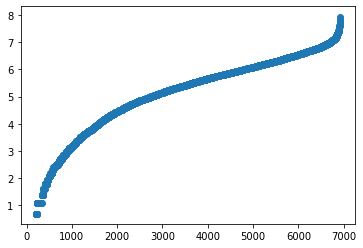

In [200]:
plt.scatter(x = np.arange(0, len(df['판매량'])), y = np.sort(np.log(df['판매량'].values)))